# Prelude

Connect the notebook local directory to Google drive for easy access to the data

In [1]:
from IPython.display import clear_output

In [2]:
!pip install lmfit
clear_output()

In [3]:
import os
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit.models import ConstantModel, LorentzianModel

In [4]:
if os.path.isdir("/content/heterodyne/") and os.path.isdir("/content/split_detection/"):
    pass
else:
    !unzip /content/drive/MyDrive/allan_data/heterodyne.zip
    !unzip /content/drive/MyDrive/allan_data/split_detection.zip
clear_output()

# Processing Methods

These methods make it easy to load in .CSV files containing the spectra data.

In [5]:
def columns_to_array(df):
    """
    Create individual numpy arrays from columns of a data frame

    Args:
    df (pd.DataFrame):  The data frame to convert

    Returns:
    tuple(np.array, ... np.array):  The columns of `df` as elements of a tuple.
                                    Length of tuple depends on number of columns.
    """
    result = []
    for _, col_data in df.iteritems():
        result.append(col_data.values)
    return result

def load_csv_file(fpath, spectra_units):
    """
    Load a single csv file into memory as a pandas.DataFrame
    
    Args:
    fpath (str):  The relative path to the csv file

    spectra_units (str):  Units to use for the spectra values.
                          Typically m^2/Hz or V^2/Hz.
    """
    return pd.read_csv(fpath, names=["Frequency (Hz)", f"Spectra ({spectra_units})"])

def process_csv_file(fpath, spectra_units):

    """
    Load a single CSV file into memeory as numpy arrays

    Args:
    fpath (str):  The relative path to the binary file

    vec (np.array):  A column vector

    Returns:
    tuple(np.array, ... np.array):  The columns of `df` as elements of a tuple.
                                    Length of tuple depends on number of columns.
    """

    df = load_csv_file(fpath, spectra_units)

    return columns_to_array(df)

def match_filenames_in_dir(pattern, dirpath):

    """
    Search a directory tree for all filenames which match a specified pattern

    Args:
    pattern (str):  Expression for the filename template
    directory(str):  Path to directory where data files are located

    Returns:
    (list(str)):  List of all the filenames which match a specified pattern
    """

    # List of all found files that match pattern
    result = []
    # Walk the tree
    for root, dirs, files in os.walk(dirpath):
        # Only care about files within the directory
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

In [6]:
def sort_key(filepath):
    """
    Find the file number from the path to a file.
    Example:  Extract the number 109 from /.../cha_st80_109.CSV
    """

    filename = filepath.split('/')[-1]
    filenumber = filename.split('_')[-1].strip(".CSV")
    return int(filenumber)

# Constant Patterns for Data sets

In [7]:
data_sets = {"cha":{"directory":"/content/split_detection/",
                    "pattern":"cha_st80_*.CSV",
                    "units":"m^2/Hz"},
             "chb":{"directory":"/content/split_detection/",
                    "pattern":"chb_st80_*.CSV",
                    "units":"m^2/Hz"},
             "het":{"directory":"/content/heterodyne/",
                    "pattern":"het_st80_*.CSV",
                    "units":"V^2/Hz"}}

# Visualize the Data

Superimpose the data onto a single plot (one for each data set) to get a general sense for shape and magnitude.

In [8]:
def super_plot(pattern, directory, title, units="m^2/Hz"):

    """
    Superimpose spectra onto a single plot
    """
    
    # Get a list of files
    filepaths = match_filenames_in_dir(pattern, directory)
    filepaths.sort(key=sort_key)
    
    # Set up a single figure 
    fig = plt.figure()
    ax = fig.add_subplot(111, title=title, xlabel="Frequency (Hz)", ylabel=f"Spectra ({units})")

    # Add lines to the figure
    for path in filepaths:
        df = load_csv_file(path, f"{units}")
        freq = df["Frequency (Hz)"]
        spectra = df[f"Spectra ({units})"]
        ax.plot(freq, spectra)
    
    plt.show()
    return 

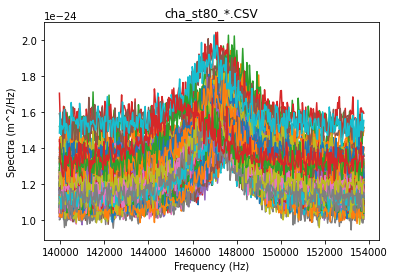

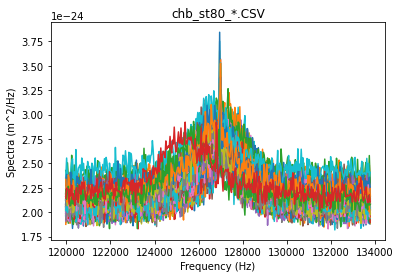

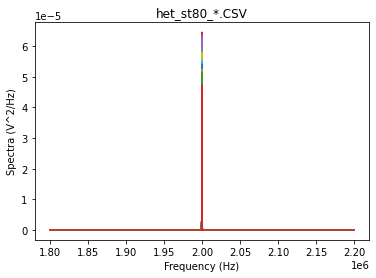

In [9]:
for data in data_sets.values():
    super_plot(data["pattern"], data["directory"], data["pattern"], data["units"])
    print("\n")

For the Heterodyne data, it would be helpful to focus the view on the central peak.

In [10]:
def center_zoom(arr, window):
    """
    Select elements within a window centered around a peak
    """

    center = len(arr)//2
    left = center-window//2
    right = center+window//2
    selection = arr[left:right]
    return selection 

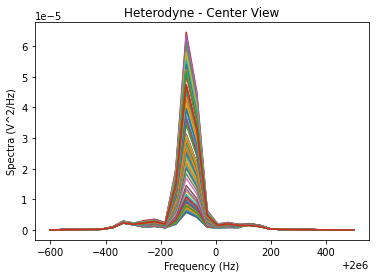

In [11]:
window_size = 30
units = "V^2/Hz"

# Get a list of files
filepaths = match_filenames_in_dir(data_sets["het"]["pattern"], data_sets["het"]["directory"])
filepaths.sort(key=sort_key)

# Set up a single figure 
fig = plt.figure()
ax = fig.add_subplot(111, title="Heterodyne - Center View", xlabel="Frequency (Hz)", ylabel=f"Spectra ({units})")

# Add lines to the figure
for path in filepaths:
    df = load_csv_file(path, f"{units}")
    freq = center_zoom(df["Frequency (Hz)"], window_size)
    spectrum = center_zoom(df[f"Spectra ({units})"], window_size)
    ax.plot(freq, spectrum)

plt.show()


# Lorentzian Fit

As seen in the previous section, sideband data (`cha_...` and `chb_...`) contain a single peak. A spectrum can be fit with the Lorentzian. 

In the following section, a fitting procedure is defined.

In [12]:
def lorentz_1d(amp, sigma, center):
    """
    Implement 1D Lorentzian as seen
    https://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Lorentz1D.html
    """
    return (amp*sigma**2)/(sigma**2+(x-center)**2)

In [13]:
# Calculate the percent error between the area under
# the raw spectra data and the area under the best fit curve
pct_err = lambda a, e : 100*abs(e-a)/abs(a)

---

In [14]:
def plot_best_fit(freq, spectrum, best_fit_arr, title, units="m^2/Hz"):
    """
    Plot the best fit curve on top of a single spectra
    """

    plt.plot(freq, spectrum, label="Spectra")
    plt.plot(freq, best_fit_arr, label="Best Fit")
    plt.legend()
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(f"Spectra ({units})")
    plt.title(title)
    plt.show()
    return 

In [15]:
def extract_single_peak(freq, spectrum):

    """
    Applies a Lorentzian fit function to the peak and extract 
    its area, mechanical frequency, and linewidth
    """
    
    # Build the model
    peak = LorentzianModel()
    background = ConstantModel()

    # Define model parameters
    pars = background.make_params(c=spectrum.min())
    pars += peak.guess(spectrum, x=freq)

    model = peak + background

    # Fit the model 
    out = model.fit(spectrum, pars, x=freq)
    
    # Extract area, mechanical frequency, and linewidth
    raw_area = np.trapz(spectrum)
    fit_area = np.trapz(out.best_fit)
    mech_freq = out.best_values["amplitude"]
    linewidth = 2*out.best_values["sigma"]


    return {"raw area":raw_area,
            "fit area":fit_area,
            "mechanical frequency":mech_freq,
            "linewidth":linewidth,
            "best fit object":out}

## Example:  Determining the Best Fit Curve and Extracting Values

The following section demonstrates finding a best fit curve for a single peak spectrum. In this case, `cha_st80_1.CSV`

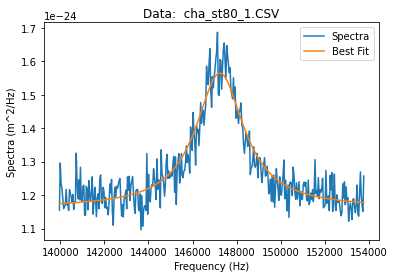

In [16]:
# Apply fitting to just 1 spectra 
cha1 = load_csv_file("/content/split_detection/cha_st80_1.CSV", "m^2/Hz")
freq = cha1["Frequency (Hz)"]
spectrum = cha1["Spectra (m^2/Hz)"]

cha1_best_fit = extract_single_peak(freq, spectrum)["best fit object"]
plot_best_fit(freq, spectrum, cha1_best_fit.best_fit, "Data:  cha_st80_1.CSV")

Examine values from the best fit model

In [17]:
extract_single_peak(freq, spectrum)

{'best fit object': <lmfit.model.ModelResult at 0x7fb03fc8f910>,
 'fit area': 4.593357235347419e-22,
 'linewidth': 2670.2883529663086,
 'mechanical frequency': 1.691638732823799e-21,
 'raw area': 4.593058036684815e-22}

---

# How Does Applying a Fit Affect Area Under Peak?

- Try: Simpson's rule 
    - 100x the percent error
    - Reverted back to only using the trapezoid rule

In [18]:
def single_peak_area_differences(dataset):

    """
    Compute the percent difference between the area under the 
    Lorentzian fit and the raw data using the trapezoid integration rule
    """

    directory = dataset["directory"]
    pattern = dataset["pattern"]
    units = dataset["units"]

    filepaths = match_filenames_in_dir(pattern, directory)
    filepaths.sort(key=sort_key)

    trapz_errors = []
    simpson_errors = []

    for path in filepaths:
        df = load_csv_file(path, units)
        freq = df["Frequency (Hz)"]
        spectrum = df[f"Spectra ({units})"]

        best_fit = extract_single_peak(freq, spectrum)
        trapz_errors.append(pct_err(best_fit["raw area"], best_fit["fit area"]))
    
    plt.bar(np.arange(1, 125), trapz_errors, label="Trapezoid Rule")
    plt.legend()
    plt.xlabel("File Number")
    plt.ylabel("Percent Error (%)")
    plt.title(f"Data Set:  {pattern}")
    plt.show()
    return 

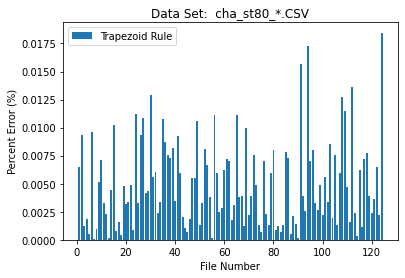

In [19]:
# Channel A
single_peak_area_differences(data_sets["cha"])

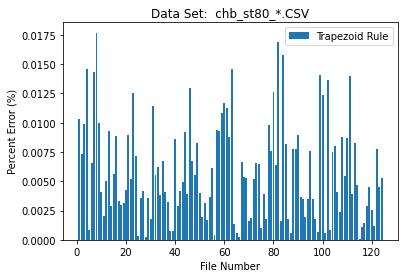

In [20]:
# Channel B
single_peak_area_differences(data_sets["chb"])